# Gradient Boosting Machines Model

### GBM model will be the first machine learning model, that we shall built. 

###### https://en.wikipedia.org/wiki/Gradient_boosting
###### Please refer the above link for details on Gradient Boosting

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import os as os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Set working dierctory
os.chdir("..")
cwd = os.getcwd()
os.chdir(f'{cwd}\\Data\\Model data\\')

In [3]:
# Read the dataset
data = pd.read_csv("Final_model_dataset.csv")
data = data.fillna(0)

In [4]:
# Set the FIPS variable as index
data = data.set_index("FIPS")

## Required Functions for this Model

In [5]:
# Initial Variable reduction using GBM variable importance
def Variable_Reduction(X_train, independent_vars, y_train):
    X = X_train[independent_vars]
    y = y_train
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, 
                                     criterion='friedman_mse', min_samples_split=0.05, max_depth=4, random_state=12345,
                                     max_features="sqrt")
    clf.fit(X,y)
    VarSel = pd.DataFrame(independent_vars)
    VarSel.columns = ["Variables"]
    VarSel["Importance"] = (clf.feature_importances_)
    return VarSel

In [6]:
def Drop_one_var(X_train, independent_vars, y_train):
    VarSel = Variable_Reduction(X_train, independent_vars, y_train)
    VarSel = VarSel.sort_values(["Importance"], ascending=False)
    min_imp = VarSel["Importance"].min()
    VarSel = VarSel[VarSel["Importance"]> min_imp]
    return list(VarSel["Variables"])

In [7]:
def KS_Table(dataset):
    tmp_df = dataset.copy()
    tmp_df['bin'] = pd.qcut(tmp_df["Prob"], q=10, duplicates='drop')
    tmp1 = (tmp_df.groupby("bin").count()).drop("Prob",axis=1)
    tmp2 = (tmp_df.groupby("bin").sum()).drop("Prob",axis=1)
    tmp3 = (tmp_df.groupby("bin").mean()).drop("y",axis=1)
    tmp1.columns = ["Total"]
    tmp2.columns = ["Goods"]
    tmp3.columns = ["PredRR"]
    tmp = tmp1.merge(tmp2, how="outer", left_index=True, right_index=True)
    tmp = tmp.merge(tmp3, how="outer", left_index=True, right_index=True)
    tmp = tmp.sort_values("PredRR", ascending=False)
    tmp["ObsRR"] = tmp["Goods"]/tmp["Total"]
    tmp["Bads"] = tmp["Total"] - tmp["Goods"]
    tmp["Perct_Goods"] = tmp["Goods"]/tmp["Goods"].sum()
    tmp["Perct_Bads"] = tmp["Bads"]/tmp["Bads"].sum()
    tmp["Cum_Perct_Goods"] = tmp["Perct_Goods"].cumsum()
    tmp["Cum_Perct_Bads"] = tmp["Perct_Bads"].cumsum()
    tmp["KS"] = np.round(tmp["Cum_Perct_Goods"] - tmp["Cum_Perct_Bads"],3)*100
    return tmp

In [8]:
def Iter_GBM_HyperParam(X_train, y_train, X_test, y_test, independent_vars, NTrees, Depth, lr, subsample):
    X1 = X_train[independent_vars]
    y = y_train.ravel()
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=lr, n_estimators=NTrees, subsample=subsample, 
                                     criterion='friedman_mse', min_samples_split=0.05, max_depth=Depth, random_state=12345,
                                     max_features="sqrt")
    clf.fit(X1,y)
    # Performance on train sample
    y_hat = clf.predict_proba(X1)
    results_train = pd.DataFrame()
    results_train["Prob"] = (y_hat[: ][: , 1])
    results_train["y"] = y_train.ravel()
    KS_Train_met = KS_Table(results_train)["KS"].max()
    
    #Performance on test sample
    X2 = X_test[independent_vars]
    y_hat = clf.predict_proba(X2)
    results_test = pd.DataFrame()
    results_test["Prob"] = (y_hat[: ][: , 1])
    results_test["y"] = y_test.ravel()
    KS_Test_met = KS_Table(results_test)["KS"].max()
    
    return KS_Train_met, KS_Test_met

### As the initial set of variables is really high (10,000+), we shall pick only the top variables based on Information value (IV).
### IV was calculated in Logistic Regression model, and hence shall read the same csv file to save resources

In [9]:
# Read IV file
IV_table = pd.read_csv("Information_Value.csv")

In [10]:
# Put a cut-off of IV>0.10
IV_table = IV_table[IV_table["IV"]>0.10]

In [11]:
Initial_Variables = list(IV_table["Variables"])
Initial_Variables.remove("Mortality_change_2012_2014")

### Feature Scaling and PCA

In [12]:
# Standardizing the features
X = data[Initial_Variables]
StdSclr = StandardScaler().fit(X)
X1 = StdSclr.transform(X)

In [13]:
# PCA transformation
pca = PCA(n_components=20)
pcafit = pca.fit(X1)
pricipalComponents = pcafit.transform(X1)

In [14]:
# Convert the Principal Components into a pandas dataframe
arr = list(np.arange(0,20,1))
colnames = [("PCA_"+str(ar)) for ar in arr]
principalDf = pd.DataFrame(data = pricipalComponents, columns = colnames)
principalDf.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
0,30.800210,-0.080506,-19.539556,-0.521350,-4.892962,10.687493,-4.427965,-0.226237,1.437680,1.142730,1.398541,-3.349505,-1.352425,-2.151346,0.662061,3.573247,-4.404153,5.230679,4.531200,0.445413
1,12.740122,10.938975,3.637980,-4.474000,-0.578941,-0.353140,-5.299740,-2.149521,4.546507,1.168551,0.804265,-10.136213,1.518269,3.725885,-6.935435,2.905359,-2.771966,3.488961,3.783354,-1.189574
2,39.124687,-4.440052,-0.806659,14.784193,-9.635509,-3.036066,-4.898818,2.744003,-2.873641,-0.837786,-7.232776,-2.673396,-5.154757,1.508923,-6.775394,0.515631,-8.747493,0.930424,2.856062,6.830455
3,41.827004,-5.801363,-14.667366,9.847788,-7.560088,11.980695,-2.048175,-4.252003,-5.715849,-5.598667,-8.055208,1.673605,-0.945552,-2.294522,-4.465388,1.328500,-7.930982,3.100608,0.200714,2.369855
4,24.219103,-3.018081,-9.340286,-2.979836,-3.470174,8.440551,-2.191821,-7.379514,4.609513,-6.045881,-0.509905,2.351524,5.192318,-1.261350,3.257939,-1.168660,-3.119961,1.747020,0.828917,1.446436


## Selecting the model

In [15]:
# Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(principalDf, data["Target"], test_size=0.33, random_state=12345)

In [16]:
initial_vars = list(principalDf.columns)

In [17]:
NTrees = [50, 100]
Depth = [2,3,4]
Learn_Rate = [0.01, 0.05, 0.10]
subsamp = [0.7, 0.8]
expected_length = (len(NTrees)*len(Depth)*len(Learn_Rate)*len(subsamp)*len(initial_vars))
KS_Train = [None]*expected_length
KS_Test = [None]*expected_length
NTrees_met = [None]*expected_length
Depth_met = [None]*expected_length
LR_met = [None]*expected_length
subsamp_met = [None]*expected_length
No_Vars = [None]*expected_length

In [18]:
ite = 0
while(len(initial_vars)>5):
    for i in range(0, len(NTrees)):
        for j in range(0, len(Depth)):
            for k in range(0,len(Learn_Rate)):
                for l in range(0, len(subsamp)):
                    NTrees_met[ite] = NTrees[i]
                    Depth_met[ite] = Depth[j]
                    LR_met[ite] = Learn_Rate[k]
                    subsamp_met[ite] = subsamp[l]
                    No_Vars[ite] = len(initial_vars)
                    KS_Train[ite], KS_Test[ite] = Iter_GBM_HyperParam(X_train,y_train, X_test, y_test, initial_vars, NTrees[i], 
                                                                      Depth[j], Learn_Rate[k], subsamp[l])
                    ite += 1
    initial_vars = Drop_one_var(X_train, initial_vars, y_train)
    pd.DataFrame(initial_vars).to_csv("GBM_"+str(len(initial_vars))+".csv")

In [19]:
results = pd.DataFrame()
results["No_Vars"] = No_Vars[0:ite]
results["NTrees_met"] = NTrees_met[0:ite]
results["Depth_met"] = Depth_met[0:ite]
results["Learning_Rate"] = LR_met[0:ite]
results["Subsample"] = subsamp_met[0:ite]
results["KS_Train"] = KS_Train[0:ite]
results["KS_Test"] = KS_Test[0:ite]

In [20]:
print(results.to_string())

     No_Vars  NTrees_met  Depth_met  Learning_Rate  Subsample  KS_Train  KS_Test
0         20          50          2           0.01        0.7      47.6     48.3
1         20          50          2           0.01        0.8      48.3     47.1
2         20          50          2           0.05        0.7      51.4     49.0
3         20          50          2           0.05        0.8      52.6     48.3
4         20          50          2           0.10        0.7      55.2     46.4
5         20          50          2           0.10        0.8      55.2     46.8
6         20          50          3           0.01        0.7      51.1     47.0
7         20          50          3           0.01        0.8      50.5     49.0
8         20          50          3           0.05        0.7      57.4     47.7
9         20          50          3           0.05        0.8      57.4     48.3
10        20          50          3           0.10        0.7      61.5     47.7
11        20          50    

### As the number of variables decrease, the model tends to overfit on Train sample. The KS for train sample increases a lot, whereas the KS for Test samples fall a lot

### 8 variable model, with 100 trees, depth of  3, subsample rate of 0.7, and learning rate of 0.05, has a KS of 52.4% for Train sample and   44.6 % for Test sample

### Evaluate the performance of 8 variable GBM Model

In [21]:
selected_vars = pd.read_csv("GBM_8.csv")
selected_vars = list(selected_vars["0"])

In [22]:
X = X_train[selected_vars]
y = y_train.ravel()
clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=100, subsample=0.7, 
                                     criterion='friedman_mse', min_samples_split=0.05, max_depth=3, random_state=12345,
                                     max_features="sqrt")
clf.fit(X,y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=0.05,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=12345, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Performance of Train Sample

In [23]:
os.chdir("..")
os.chdir("..//Images")

In [24]:
y_hat = clf.predict_proba(X_train[selected_vars])
results_train = pd.DataFrame()
results_train["Prob"] = (y_hat[: ][: , 1])
results_train["y"] = y_train.ravel()

In [25]:
KS_Train = KS_Table(results_train)
print("The KS for the model is:", round(KS_Train["KS"].max(),2),"%")

The KS for the model is: 59.3 %


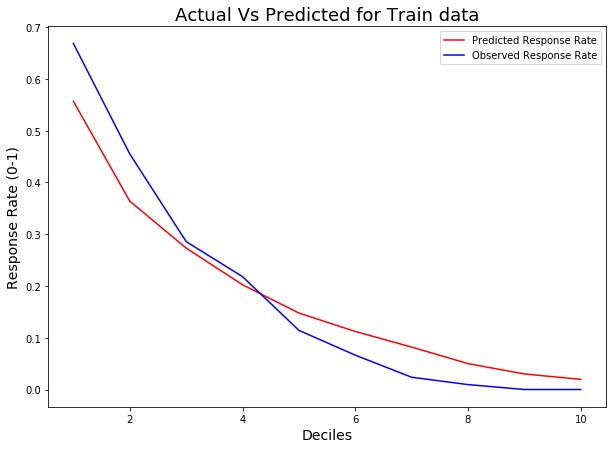

In [26]:
import matplotlib.pyplot as plt
deciles = np.arange(1,11,1)
plt.figure(figsize=(10,7))
plt.plot(deciles, KS_Train["PredRR"],'-r',label="Predicted Response Rate")
plt.plot(deciles, KS_Train["ObsRR"],'-b', label="Observed Response Rate")
plt.xlabel("Deciles", fontsize=14)
plt.ylabel("Response Rate (0-1)", fontsize=14)
plt.title("Actual Vs Predicted for Train data", fontsize=18)
plt.legend(fontsize=10)
plt.savefig('GBM_Act_vs_Pred_train.png')
plt.show()

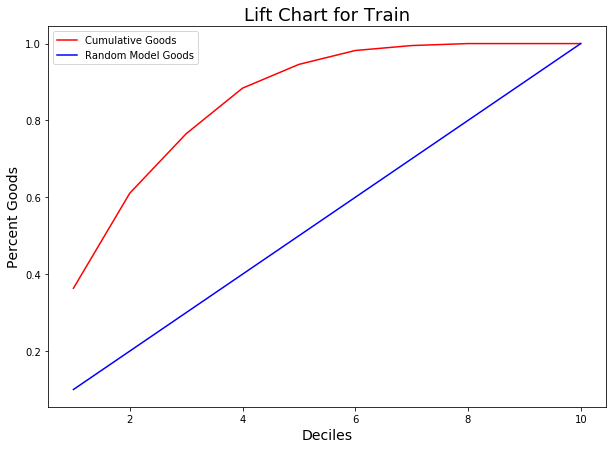

In [27]:
deciles = np.arange(1,11,1)
rand = deciles/10
plt.figure(figsize=(10,7))
plt.plot(deciles, KS_Train["Cum_Perct_Goods"],'-r',label="Cumulative Goods")
plt.plot(deciles, rand,'-b', label="Random Model Goods")
plt.xlabel("Deciles", fontsize=14)
plt.ylabel("Percent Goods", fontsize=14)
plt.title("Lift Chart for Train", fontsize=18)
plt.legend(fontsize=10)
plt.savefig("GBM_LiftChart_trainsample.png")
plt.show()

In [28]:
# Accuracy for training dataset
print ("Accuracy for training dataset is:", round(clf.score(X_train[selected_vars], y_train),2))

Accuracy for training dataset is: 0.84


### Performance of Test Sample

In [29]:
y_hat = clf.predict_proba(X_test[selected_vars])
results_test = pd.DataFrame()
results_test["Prob"] = (y_hat[: ][: , 1])
results_test["y"] = y_test.ravel()

In [30]:
KS_Test = KS_Table(results_test)
print("The KS for the model is:", round(KS_Test["KS"].max(),2),"%")

The KS for the model is: 47.8 %


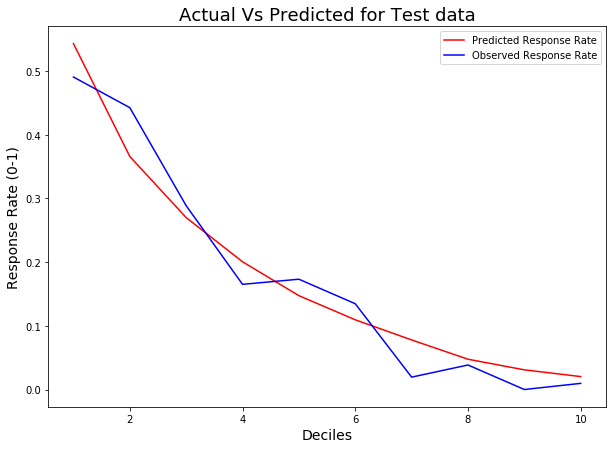

In [31]:
import matplotlib.pyplot as plt
deciles = np.arange(1,11,1)
plt.figure(figsize=(10,7))
plt.plot(deciles, KS_Test["PredRR"],'-r',label="Predicted Response Rate")
plt.plot(deciles, KS_Test["ObsRR"],'-b', label="Observed Response Rate")
plt.xlabel("Deciles", fontsize=14)
plt.ylabel("Response Rate (0-1)", fontsize=14)
plt.title("Actual Vs Predicted for Test data", fontsize=18)
plt.legend(fontsize=10)
plt.savefig("GBM_Act_vs_Pred_test.png")
plt.show()

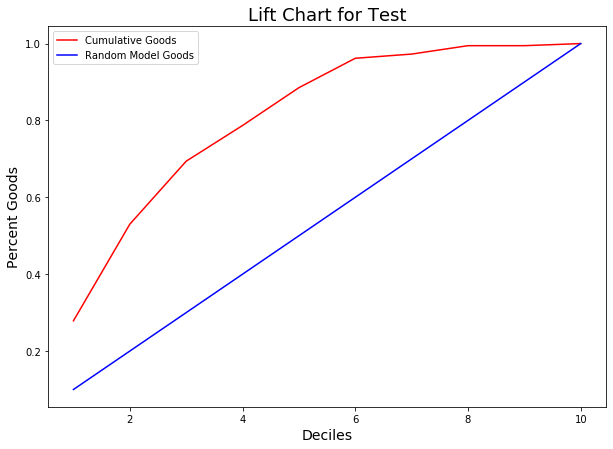

In [32]:
deciles = np.arange(1,11,1)
rand = deciles/10
plt.figure(figsize=(10,7))
plt.plot(deciles, KS_Test["Cum_Perct_Goods"],'-r',label="Cumulative Goods")
plt.plot(deciles, rand,'-b', label="Random Model Goods")
plt.xlabel("Deciles", fontsize=14)
plt.ylabel("Percent Goods", fontsize=14)
plt.title("Lift Chart for Test", fontsize=18)
plt.legend(fontsize=10)
plt.savefig('GBM_LiftChart_testsample.png')
plt.show()

In [33]:
# Accuracy for test dataset
print ("Accuracy for Test dataset is:", round(clf.score(X_test[selected_vars], y_test),2))

Accuracy for Test dataset is: 0.83
